In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import qiskit
from functools import reduce
import time
import pickle


In [2]:
def pauli_str_to_unitary(pstr):
    def char_to_pauli(c):
        if c == "I":
            return np.eye(2)
        elif c == "X":
            return np.array([[0, 1], [1, 0]])
        elif c == "Y":
            return np.array([[0, -1j], [1j, 0]])
        elif c == "Z":
            return np.array([[1, 0], [0, -1]])
        else:
            raise ValueError(f"Invalid Pauli character: {c}")
    
    return reduce(np.kron, [char_to_pauli(c) for c in pstr], np.array([[1]]))

In [3]:
def spin_chain_H(n, J=1, g=1, type="transverse"):
    if type == "transverse":
        H = np.zeros((2**n, 2**n))
        for i in range(n):
            if i < n-1:
                pstr = list("I"*n)
                pstr[i] = pstr[i+1] = "Z"
                H += pauli_str_to_unitary(pstr)
            
            pstr = list("I"*n)
            pstr[i] = "X"
            H += g*pauli_str_to_unitary(pstr)

        H *= -J
    return H

In [4]:
def rand_prod_state(n):
    def rand_state():
        return qiskit.quantum_info.random_statevector(2)

    return reduce(np.kron, [rand_state() for _ in range(n)], np.array(1))

In [5]:
def expect(state, H):
    if state.ndim == 1:
        res = state.conj().T @ H @ state
    else:
        rho = state
        res = np.trace(rho @ H)
    
    assert np.isclose(res.imag, 0)
    return res.real # real-valued observables

def outer(state):
    psi = state.reshape(-1, 1)
    return psi @ psi.conj().T

def trdist(rho, sigma):
    return np.sum(np.abs(np.linalg.svdvals(rho-sigma))) / 2

In [6]:
gcauchy_pdf = lambda u: 1/np.pi * 1/(1+(u/np.sqrt(2))**4)

def sample_gcauchy(M=1):
    cs = []
    # pdf = lambda u: 1/np.pi * 1/(1+(u/np.sqrt(2))**4)
    thresh = (1+np.sqrt(5))/2 # sup u of pdf(u)/cauchypdf(u) = golden ratio
    while len(cs) < M:
        c = scipy.stats.cauchy.rvs()
        u = scipy.stats.uniform.rvs()
        h = (1+c**2)/(1+(c/np.sqrt(2))**4)
        if u < h/thresh:
            cs.append(c)

    return np.array(cs) if M > 1 else cs[0]

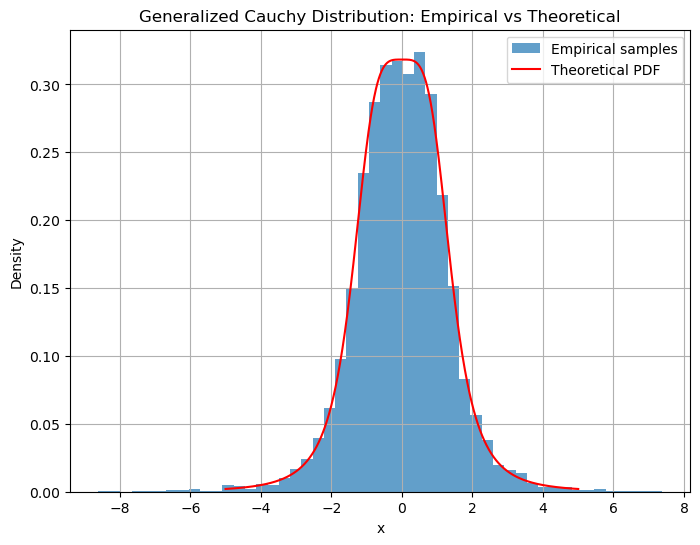

In [7]:
T = int(1e4)
samples = sample_gcauchy(T).flatten()

plt.figure(figsize=(8,6))
x = np.linspace(-5, 5, 1000)
pdf = lambda u: 1/np.pi * 1/(1+(u/np.sqrt(2))**4)

plt.hist(samples[np.abs(samples) <= 10], bins=50, density=True, alpha=0.7, label='Empirical samples')
plt.plot(x, pdf(x), 'r-', label='Theoretical PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Generalized Cauchy Distribution: Empirical vs Theoretical')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
class Hamiltonian:
    def __init__(self, H):
        self.H = H
        self.n = H.shape[0]

        # Eigendecomposition of Hamiltonian
        eigenvals, eigenvecs = np.linalg.eigh(self.H)
        self.U = eigenvecs  # Unitary that diagonalizes H
        self.D = np.diag(eigenvals)  # Diagonal matrix of eigenvalues
        self.lam = eigenvals
        self.ground = eigenvecs[:, 0]
    
    def ITE(self, H, beta, method="fast"):
        if method == "direct":
            return scipy.linalg.expm(-beta * H)
        elif method == "fast":
            return self.U @ np.diag(np.exp(-beta * self.lam)) @ self.U.conj().T
        else:
            raise ValueError(f"Invalid method: {method}")

    def RTE(self, H, t, method="fast"):
        if method == "direct":
            return scipy.linalg.expm(-1j * H * t)   
        elif method == "fast":
            return self.U @ np.diag(np.exp(-1j * self.lam * t)) @ self.U.conj().T
        else:
            raise ValueError(f"Invalid method: {method}")
    
    def iITE(self, state, beta, method="fast"):
        psi_ = self.ITE(self.H, beta, method=method) @ state
        psi = psi_ / np.linalg.norm(psi_)
        return psi

    def iITE_rand_iRTE(self, state, beta, M = 1000, distrib="gcauchy", method="fast", **kwargs):
        psi = self.iITE(state, beta, method=("direct" if method == "direct" else "fast"))

        if method == "direct":
            samples = np.array([sample_gcauchy() for _ in range(M)])
            states = [self.RTE(self.H, t) @ psi for t in samples]
            rho = sum([outer(s) for s in states]) / M
        elif method == "fast":
            samples = np.array([sample_gcauchy() for _ in range(M)])
            c = self.U.conj().T @ psi
            phases = np.exp(-1j * np.outer(self.lam, samples))  # (n, M): phase factors exp(-i λ_i t_j)
            c_t = c[:, None] * phases                            # (n, M): c * exp(-i λ t_j)
            psi_t = self.U @ c_t                                  # (n, M): ψ_t = U @ c_t
            rho = psi_t @ psi_t.conj().T / M            # (1/M) Σ_j |ψ_t_j⟩⟨ψ_t_j|
        elif method == "integrate": 
            # \int dt p(t) e^{-iHt} e^{-\beta H} \rho_0 e^{-\beta H} e^{iHt} 
            # \int dt p(t) U e^{(-\beta-it) lam} U^dagger \rho_0 U e^{(-beta+it) lam} U^dagger
            rho_0 = outer(psi)
            rho_U = self.U.conj().T @ rho_0 @ self.U
            
            def integrand(t):
                return gcauchy_pdf(t) * self.U @ np.diag(np.exp(-1j * t * self.lam)) @ rho_U @ np.diag(np.exp(1j * t * self.lam)) @ self.U.conj().T
            
            rho = scipy.integrate.quad_vec(integrand, -np.inf, np.inf, **kwargs)[0]
        else:
            raise ValueError(f"Invalid method: {method}")
        
        return rho
    

In [19]:
hamil = Hamiltonian(spin_chain_H(4))

psi0 = rand_prod_state(4)
beta = 1

# Time each method averaged over 10 runs
times_integrate = []
times_direct = []
times_fast = []

for _ in range(10):
    start = time.time()
    rho = hamil.iITE_rand_iRTE(psi0, beta, M=int(1e3), distrib="gcauchy", method="integrate", epsrel=1e-4)
    times_integrate.append(time.time() - start)
    
    start = time.time()
    rho_2 = hamil.iITE_rand_iRTE(psi0, beta, M=int(1e3), distrib="gcauchy", method="direct") 
    times_direct.append(time.time() - start)
    
    start = time.time()
    rho_3 = hamil.iITE_rand_iRTE(psi0, beta, M=int(1e3), distrib="gcauchy", method="fast")
    times_fast.append(time.time() - start)

print(f"Average times:")
print(f"Integrate: {np.mean(times_integrate):.3f}s")
print(f"Direct: {np.mean(times_direct):.3f}s") 
print(f"Fast: {np.mean(times_fast):.3f}s")


Average times:
Integrate: 0.033s
Direct: 0.050s
Fast: 0.040s


In [12]:
def spin_cov(rho, spin_ind):
    n = int(np.log2(rho.shape[0]))
    pstr = list('I'*n)
    pstr[spin_ind] = 'X'
    expect_Xi = expect(rho, pauli_str_to_unitary(pstr))
    pstr[spin_ind+1] = 'X'
    expect_XiXiplus1 = expect(rho, pauli_str_to_unitary(pstr))
    pstr[spin_ind] = 'I'
    expect_Xiplus1 = expect(rho, pauli_str_to_unitary(pstr))
    spin_cov = expect_XiXiplus1 - expect_Xi*expect_Xiplus1
    return spin_cov

In [22]:
n = 4
g = 1.5
H = spin_chain_H(n, g=g)
hamil = Hamiltonian(H)
spin_ind = 2
T = 10

betas = np.linspace(0, 5, 20)
data = {'energies': dict(), 'spincov': dict(), 'trd': dict()}

method_names = ['iITE', 'iITE_rand_iRTE']
methods = [
    lambda *args: outer(hamil.iITE(*args, method="fast")),
    lambda *args: hamil.iITE_rand_iRTE(*args, M=int(1e3), distrib="gcauchy", method="integrate", epsrel=1e-6)
]

psi0s = [rand_prod_state(n) for _ in range(T)]
for mi, m in enumerate(methods):
    mn = method_names[mi]
    method = methods[mi]

    for psi0 in psi0s:
        d = {k: [] for k in data}
        for beta in betas:
            rho = method(psi0, beta)

            d['energies'].append(expect(rho, H))
            d['trd'].append(trdist(rho, outer(hamil.ground)))

            d['spincov'].append(spin_cov(rho, spin_ind))
        
        for k in data:
            if mn not in data[k]: data[k][mn] = []
            data[k][mn].append(d[k])

    for k in data: data[k][mn] = np.array(data[k][mn])


In [27]:
fn = f'data_n{n}_g{g}_spin{spin_ind}_T{T}.pkl'
with open(fn, 'wb') as f:
    pickle.dump(data, f)


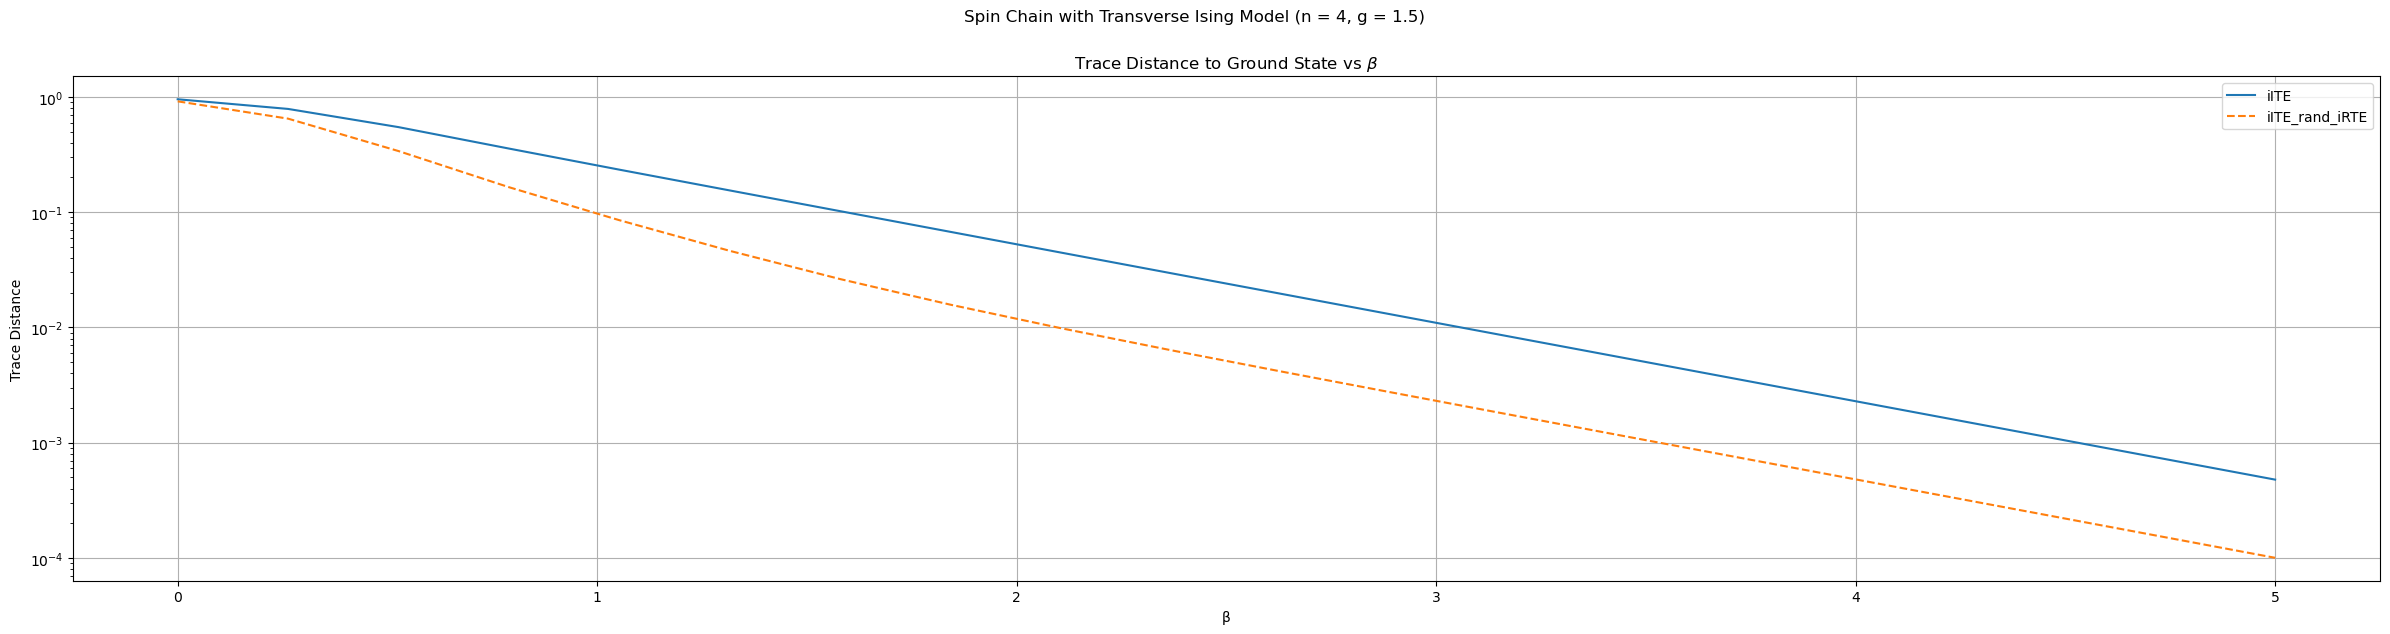

In [ ]:
def energy_plot(ax, data, method_names, betas):
    for method in method_names:
        linestyle = '-' if method == 'iITE' else '--'
        ax.plot(betas, np.mean(data['energies'][method], axis=0), linestyle, label=method)
    ax.set_xlabel('β')
    ax.set_ylabel(r'Energy $\langle \psi | H | \psi \rangle$')
    ax.set_title(r'Energy vs $\beta$')
    ax.legend()
    ax.grid(True)

def trd_plot(ax, data, method_names, betas):
    for method in method_names:
        linestyle = '-' if method == 'iITE' else '--'
        y_data = np.mean(data['trd'][method], axis=0)
        ax.plot(betas, y_data, linestyle, label=method)
        
        # Calculate line of best fit on log scale
        # log_y = np.log(y_data)
        # slope, intercept = np.polyfit(betas, log_y, 1)
        # fit_line = np.exp(slope * betas + intercept)
        # ax.plot(betas, fit_line, linestyle, alpha=0.5, 
        #         label=f'{method} fit (slope={slope:.3f})')
        # print(f"Slope for {method}: {slope:.3f}")
        
    ax.set_xlabel('β')
    ax.set_ylabel(r'Trace Distance')
    ax.set_title(r'Trace Distance to Ground State vs $\beta$')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

def spincov_plot(ax, data, method_names, betas):
    for method in method_names:
        linestyle = '-' if method == 'iITE' else '--'
        ax.plot(betas, np.mean(data['spincov'][method], axis=0), linestyle, label=f'{method} at i = {spin_ind}')
    ax.set_xlabel('β')
    ax.set_ylabel(r'Spin Covariance')
    ax.set_title(r'Spin Covariance vs $\beta$')
    ax.legend()
    ax.grid(True)

def spincov_rel_err_plot(ax, data, method_names, betas):
    for method in method_names:
        linestyle = '-' if method == 'iITE' else '--'
        # Calculate relative error for both correlation functions
        rel_err1 = np.abs(np.mean(data['spincov'][method], axis=0) - np.mean(data['spincov']['iITE'], axis=0)) / np.abs(np.mean(data['spincov']['iITE'], axis=0))
        
        if method != 'iITE':  # Skip plotting iITE vs itself
            ax.plot(betas, rel_err1, linestyle, label=f'Relative Error at i = {spin_ind}')
    ax.set_xlabel('β')
    ax.set_ylabel('Relative Error')
    ax.set_title('Relative Error in Spin Correlations (iITE_rand_iITE w.r.t. iITE)')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

fig, (ax1) = plt.subplots(1, 1, figsize=(1*8,6))
args = data, method_names, betas
# energy_plot(ax1, *args)
trd_plot(ax1, *args)
# spincov_plot(ax2, *args)
# spincov_rel_err_plot(ax3, *args)

plt.tight_layout()
plt.suptitle(f'Spin Chain with Transverse Ising Model (n = {n}, g = {g})', y=1.05)
plt.show()

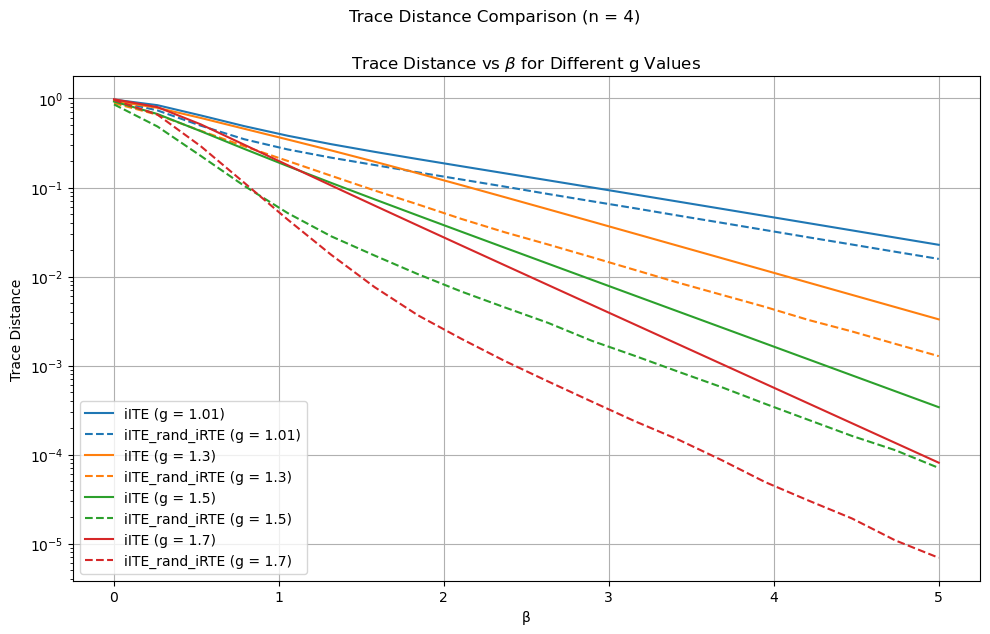

In [30]:
# Load data for different g values
g_values = [1.01, 1.3, 1.5, 1.7]
data_list = []

for g in g_values:
    fn = f'data_n{n}_g{g}_spin{spin_ind}_T{T}.pkl'
    with open(fn, 'rb') as f:
        data_list.append(pickle.load(f))

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, (g, data) in enumerate(zip(g_values, data_list)):
    for method in method_names:
        linestyle = '-' if method == 'iITE' else '--'
        ax.plot(betas, np.mean(data['trd'][method], axis=0), linestyle, 
                color=f'C{i}', label=f'{method} (g = {g})')

ax.set_xlabel('β')
ax.set_ylabel(r'Trace Distance')
ax.set_title(f'Trace Distance vs $\\beta$ for Different g Values')
ax.set_yscale('log')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.suptitle(f'Trace Distance Comparison (n = {n})', y=1.05)
plt.show()
